In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
from scipy.integrate import simps
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties 
from uncertainties import ufloat
import tensorflow as tf

plt.style.use('belle2')
#%jsroot on


%run /afs/desy.de/user/j/jipatel/MT/MC_fit/Files_After_Acceptance/Signal_Background_thesis_final/Function.ipynb

2024-09-03 11:39:09.609131: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 11:39:09.645109: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 11:39:09.646313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 11:39:11.101747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
file_bkg_mu="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/Bpmumupip4Streams.root"
file_signal_mu="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/Bpmumupip4Streams.root"


In [3]:
mc_mu_signal,mc_mu_only_signal,mc_mu_scf,mc_mu_bkg, mc_mu_signal_weight,mc_mu_only_signal_weight,mc_mu_scf_weight,mc_mu_bkg_weight = process_MC_data_combined(file_signal_mu, file_bkg_mu, 'mu', '521', 'pip', 'mumu', 0, 'rec521','PIDCorrectionAndAcceptanceWeight')


In [4]:
fit_and_integrate(mc_mu_signal, param_fl_start=0.5, param_s3_start=0.01, param_p5_start=0.02, floating=True)


/tmp/ipykernel_1250785/4262147721.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cosTheta_L'] = data['cosTheta_L'].abs()
/tmp/ipykernel_1250785/4262147721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']


name                  value  (rounded)        hesse    at limit
------------------  ------------------  -----------  ----------
extended_0.4983773             444.445  +/- 5.8e-07       False
param_fl_0.4983773            0.723507  +/-   0.082       False
param_s3_0.4983773          -0.0648507  +/-    0.12       False
param_p5_0.4983773          -0.0731707  +/-    0.33       False
Fit result valid:
True
Signal Events in MC Data = 444.3813066032041
Integrated PDF with trim: 1.0662073049866299
Integrated PDF without trim: 1.18472720451377
Proportion of data lost: 0.1000


## Yield

In [5]:
# signal
Mbc_only_signal_cb_fixed = fit_fixed('Mbc','mu', 'signal', mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed('deltaE','mu', 'signal',mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight,'cb_gauss',0)


#scf
Mbc_scf_argus_gauss_fixed= fit_fixed('Mbc','mu', 'scf', mc_mu_scf["Mbc"], mc_mu_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss_fixed= fit_fixed('deltaE','mu', 'scf', mc_mu_scf["deltaE"], mc_mu_scf_weight,'poly_gauss',0)


#bkg
Mbc_bkg_argus_gauss_fixed= fit_fixed('Mbc','mu', 'bkg',  mc_mu_bkg["Mbc"], mc_mu_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss_fixed= fit_fixed('deltaE','mu', 'bkg',  mc_mu_bkg["deltaE"], mc_mu_bkg_weight,'poly',0)



In [6]:
Signal_Mbc = mc_mu_only_signal["Mbc"]
Signal_deltaE = mc_mu_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_mu_scf["Mbc"],mc_mu_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_mu_scf["deltaE"],mc_mu_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_mu_only_signal_weight
Background_weight = pd.concat([mc_mu_scf_weight,mc_mu_bkg_weight])


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model_scf(
    Mbc_only_signal_cb_fixed,Mbc_scf_argus_gauss_fixed,deltaE_only_signal_cb_gauss_fixed,deltaE_scf_poly_gauss_fixed,
    Mbc_bkg_argus_gauss_fixed,deltaE_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight]),1,1,10000,10000
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(


InvalidArgumentError: Graph execution error:

Detected at node 'integrate_simpson_composite_1/CheckNumerics' defined at (most recent call last):
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1250785/615778294.py", line 15, in <module>
      Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model_scf(
    File "/tmp/ipykernel_1250785/3632180029.py", line 37, in fit_extended_model_scf
      nll = zfit.loss.ExtendedUnbinnedNLL(model=total_model, data=combined_data)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 997, in __init__
      super().__init__(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 797, in __init__
      super().__init__(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 209, in __init__
      self._precompile()
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 337, in _precompile
      self._call_value(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 495, in _call_value
      value = self._value(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 513, in _value
      return self._loss_func(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 298, in concrete_func
      result = func_to_run(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 1007, in _loss_func
      nll = super()._loss_func(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 816, in _loss_func
      return self._loss_func_watched(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 298, in concrete_func
      result = func_to_run(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 830, in _loss_func_watched
      nll = _unbinned_nll_tf(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 298, in concrete_func
      result = func_to_run(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 86, in _unbinned_nll_tf
      nlls = [
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 87, in <listcomp>
      _unbinned_nll_tf(model=p, data=d, fit_range=r, log_offset=log_offset)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 247, in concrete_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/loss.py", line 98, in _unbinned_nll_tf
      probs = model.pdf(data)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/util/deprecation.py", line 16, in wrapper
      return func(*args, norm=norm, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 247, in concrete_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 408, in pdf
      value = self._single_hook_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 416, in _single_hook_pdf
      return self._hook_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 419, in _hook_pdf
      return self._norm_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 422, in _norm_pdf
      return self._call_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 426, in _call_pdf
      return self._pdf(x, norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/space.py", line 3215, in new_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/models/functor.py", line 165, in _pdf
      probs = [pdf.pdf(x) * frac for pdf, frac in zip(pdfs, fracs)]
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/models/functor.py", line 165, in <listcomp>
      probs = [pdf.pdf(x) * frac for pdf, frac in zip(pdfs, fracs)]
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/util/deprecation.py", line 16, in wrapper
      return func(*args, norm=norm, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 247, in concrete_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 408, in pdf
      value = self._single_hook_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 416, in _single_hook_pdf
      return self._hook_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 419, in _hook_pdf
      return self._norm_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 422, in _norm_pdf
      return self._call_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 435, in _call_pdf
      return self._fallback_pdf(x, norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 438, in _fallback_pdf
      pdf = self._call_unnormalized_pdf(x)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 271, in _call_unnormalized_pdf
      return self._unnormalized_pdf(x)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/models/functor.py", line 356, in _unnormalized_pdf
      probs = [pdf.pdf(x, norm=False) for pdf in self.pdfs]
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/models/functor.py", line 356, in <listcomp>
      probs = [pdf.pdf(x, norm=False) for pdf in self.pdfs]
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/util/deprecation.py", line 16, in wrapper
      return func(*args, norm=norm, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 247, in concrete_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 408, in pdf
      value = self._single_hook_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 416, in _single_hook_pdf
      return self._hook_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 419, in _hook_pdf
      return self._norm_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 422, in _norm_pdf
      return self._call_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 426, in _call_pdf
      return self._pdf(x, norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/space.py", line 3215, in new_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/models/functor.py", line 165, in _pdf
      probs = [pdf.pdf(x) * frac for pdf, frac in zip(pdfs, fracs)]
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/models/functor.py", line 165, in <listcomp>
      probs = [pdf.pdf(x) * frac for pdf, frac in zip(pdfs, fracs)]
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/util/deprecation.py", line 16, in wrapper
      return func(*args, norm=norm, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 247, in concrete_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 408, in pdf
      value = self._single_hook_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 416, in _single_hook_pdf
      return self._hook_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 419, in _hook_pdf
      return self._norm_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 422, in _norm_pdf
      return self._call_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 426, in _call_pdf
      return self._pdf(x, norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/space.py", line 3215, in new_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/models/functor.py", line 165, in _pdf
      probs = [pdf.pdf(x) * frac for pdf, frac in zip(pdfs, fracs)]
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/models/functor.py", line 165, in <listcomp>
      probs = [pdf.pdf(x) * frac for pdf, frac in zip(pdfs, fracs)]
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/util/deprecation.py", line 16, in wrapper
      return func(*args, norm=norm, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 247, in concrete_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 408, in pdf
      value = self._single_hook_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 416, in _single_hook_pdf
      return self._hook_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 419, in _hook_pdf
      return self._norm_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 422, in _norm_pdf
      return self._call_pdf(x=x, norm=norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 435, in _call_pdf
      return self._fallback_pdf(x, norm)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 440, in _fallback_pdf
      pdf /= self._hook_normalization(norm=norm, options={})
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 237, in _hook_normalization
      return self._call_normalization(norm=norm, options=options)  # no _norm_* needed
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 243, in _call_normalization
      return self._fallback_normalization(norm, options=options)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 246, in _fallback_normalization
      return self._hook_integrate(limits=norm, norm=False, options=options)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 432, in _hook_integrate
      return self._norm_integrate(limits=limits, norm=norm, options=options)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 436, in _norm_integrate
      integral = self._limits_integrate(limits=limits, norm=norm, options=options)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 449, in _limits_integrate
      integral = self._call_integrate(limits=limits, norm=norm, options=options)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 464, in _call_integrate
      return self._fallback_integrate(limits=limits, norm=norm, options=options)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 484, in _fallback_integrate
      integral = self._hook_numeric_integrate(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 685, in _hook_numeric_integrate
      return self._norm_numeric_integrate(limits=limits, norm=norm, options=options)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 689, in _norm_numeric_integrate
      integral = self._limits_numeric_integrate(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 707, in _limits_numeric_integrate
      integral = self._call_numeric_integrate(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 725, in _call_numeric_integrate
      return self._fallback_numeric_integrate(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 730, in _fallback_numeric_integrate
      return self._auto_numeric_integrate(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/space.py", line 3223, in new_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 247, in concrete_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1096, in _auto_numeric_integrate
      return self._integration.auto_numeric_integrator(**integration_options)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/integration.py", line 80, in auto_integrate
      integral = simpson_integrate(func=func, limits=limits, num_points=num_points)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/integration.py", line 184, in simpson_integrate
      simpson(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/integration.py", line 163, in simpson
      return tf.reduce_sum(func(grid) * weights, axis=-1) * dx / 3.0
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 157, in _func_to_integrate
      return self.pdf(x, norm=False)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/util/deprecation.py", line 16, in wrapper
      return func(*args, norm=norm, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 247, in concrete_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 410, in pdf
      z.check_numerics(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/wrapping_tf.py", line 94, in check_numerics
      check_op = tf.debugging.check_numerics(
Node: 'integrate_simpson_composite_1/CheckNumerics'
Check if pdf output contains any NaNs of Infs : Tensor had Inf values
	 [[{{node integrate_simpson_composite_1/CheckNumerics}}]] [Op:__inference__loss_func_13238]

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_mu_signal,mc_mu_scf, mc_mu_bkg,mc_mu_signal_weight,mc_mu_scf_weight,
              mc_mu_bkg_weight,Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_mu_signal,mc_mu_scf, mc_mu_bkg,mc_mu_signal_weight,mc_mu_scf_weight,
              mc_mu_bkg_weight,deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data","$\\Delta$E(GeV)")


# Adjust layout
plt.tight_layout()

# Show plot
#plt.savefig('Bppip_q2reg0_decay_mumu.pdf')
plt.show()
   


In [7]:
# signal
Mbc_only_signal_cb_fixed = fit_fixed('Mbc','mu', 'signal', mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed('deltaE','mu', 'signal',mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight,'cb_gauss',0)

#bkg
Mbc_bkg_argus_gauss_fixed= fit_fixed('Mbc','mu', 'bkg',  mc_mu_bkg["Mbc"], mc_mu_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss_fixed= fit_fixed('deltaE','mu', 'bkg',  mc_mu_bkg["deltaE"], mc_mu_bkg_weight,'poly',0)



In [8]:
Signal_Mbc = mc_mu_only_signal["Mbc"]
Signal_deltaE = mc_mu_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_mu_scf["Mbc"],mc_mu_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_mu_scf["deltaE"],mc_mu_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_mu_only_signal_weight
Background_weight = pd.concat([mc_mu_scf_weight,mc_mu_bkg_weight])

print(sum(Signal_weight))
print(sum(Background_weight))


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model(
    Mbc_only_signal_cb_fixed,deltaE_only_signal_cb_gauss_fixed,Mbc_bkg_argus_gauss_fixed,deltaE_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight]),100,1000
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


361.1408423201478
21748.09136639618


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.2197                 439.976  -     27   +     28       False
background_yield_0.2197             21669.1  -1.5e+02   +1.5e+02       False
True


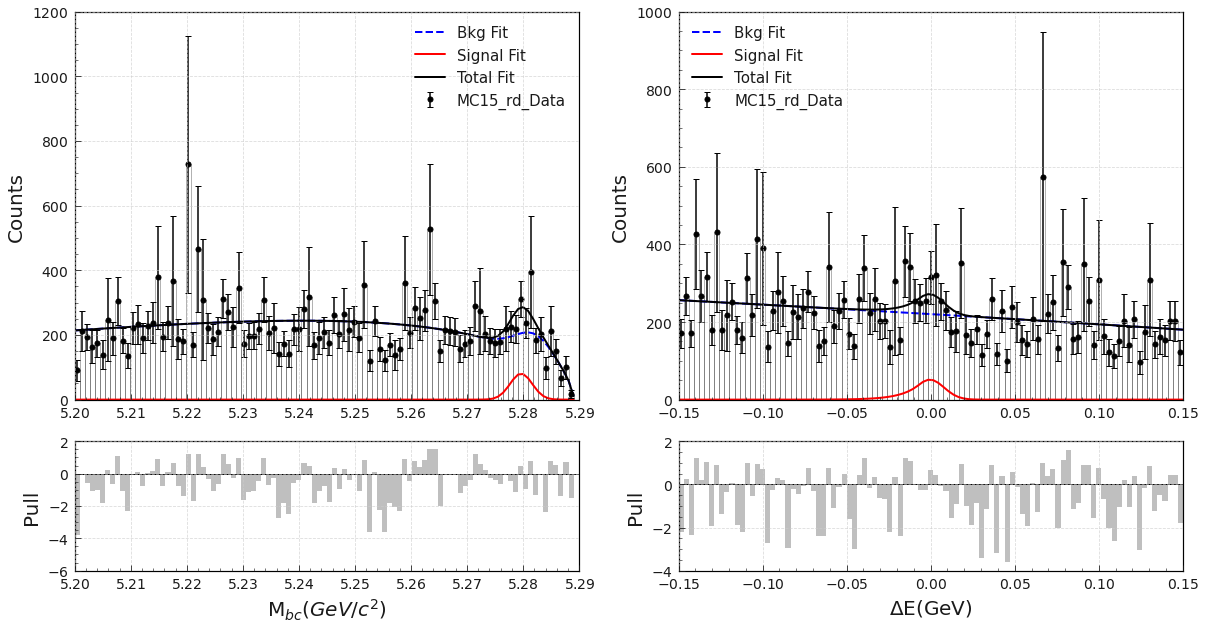

In [9]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_mu_signal,mc_mu_scf, mc_mu_bkg,mc_mu_signal_weight,mc_mu_scf_weight,
              mc_mu_bkg_weight,Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit","MC15_rd_Data", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_mu_signal,mc_mu_scf, mc_mu_bkg,mc_mu_signal_weight,mc_mu_scf_weight,
              mc_mu_bkg_weight,deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit","MC15_rd_Data","$\\Delta$E(GeV)")


# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('Bppip_q2reg0_decay_mumu_rd.pdf')
plt.show()
   

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.5651                 17138.8  -1.3e+02   +1.3e+02       False
background_yield_0.5651             16960.2  -1.3e+02   +1.3e+02       False
True
name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.2192                  106949  -3.3e+02   +3.3e+02       False
background_yield_0.2192              106403  -3.3e+02   +3.3e+02       False
True
name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.5849                  427017  -6.6e+02   +6.6e+02       False
background_yield_0.5849              426114  -6.6e+02   +6.6e+02       False
True
name                       value  (rounded)               err

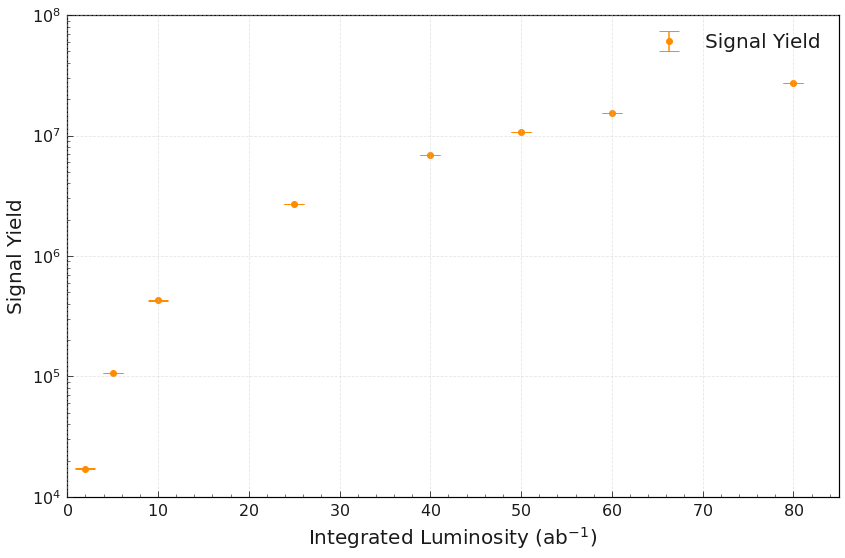

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from uncertainties import ufloat  # Ensure you import this for uncertainty handling

# Assuming result is some fitting result object with parameters
signal_yield_value = result.params[signal_extended.get_yield()]['value']
signal_yield_errors = result.params[signal_extended.get_yield()]['errors']

# Calculate the symmetric uncertainty assuming you have upper and lower errors
signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2
signal_yield_with_uncertainty = ufloat(signal_yield_value, signal_yield_error)

normalization_factor = 0.368 * 4  # Fixed normalization factor

# Define your PDFs using whatever function you have for fitting
Mbc_only_signal_cb_fixed = fit_fixed('Mbc', 'mu', 'signal', mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight, 'cb', 0)
deltaE_only_signal_cb_gauss_fixed = fit_fixed('deltaE', 'mu', 'signal', mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight, 'cb_gauss', 0)
Mbc_bkg_argus_gauss_fixed = fit_fixed('Mbc', 'mu', 'bkg', mc_mu_bkg["Mbc"], mc_mu_bkg_weight, 'argus_gauss', 0)
deltaE_bkg_poly_fixed = fit_fixed('deltaE', 'mu', 'bkg', mc_mu_bkg["deltaE"], mc_mu_bkg_weight, 'poly', 0)

# Define luminosities to loop over
luminosities = [2, 5, 10, 25,40, 50,60, 80]

# Calculate the number of events per ab^-1
n_events_per_ab1 = signal_yield_value / normalization_factor

# Arrays to store results
signal_yields = []

for lumi in luminosities:
    # Calculate the number of events for this luminosity
    n_events = int(lumi * n_events_per_ab1)  # Convert directly to an integer
    
    # Sample signal events
    Mbc_samples_signal = Mbc_only_signal_cb_fixed.sample(n=n_events).numpy()
    deltaE_samples_signal = deltaE_only_signal_cb_gauss_fixed.sample(n=n_events).numpy()

    # Combine Mbc and deltaE into a single DataFrame for signal
    samples_signal_df = pd.DataFrame({'Mbc': Mbc_samples_signal.flatten(), 'deltaE': deltaE_samples_signal.flatten()})
    
    # Calculate scaled weights for signal
    scaled_signal_weights = pd.Series((Mbc_samples_signal.flatten() + deltaE_samples_signal.flatten()) * (lumi / 0.368))
    
    # Sample background events
    Mbc_samples_bkg = Mbc_bkg_argus_gauss_fixed.sample(n=n_events).numpy()  # Use n_events directly
    deltaE_samples_bkg = deltaE_bkg_poly_fixed.sample(n=n_events).numpy()
    
    # Combine Mbc and deltaE into a single DataFrame for background
    samples_bkg_df = pd.DataFrame({'Mbc': Mbc_samples_bkg.flatten(), 'deltaE': deltaE_samples_bkg.flatten()})
    
    # Calculate scaled weights for background
    scaled_bkg_weights = pd.Series((Mbc_samples_bkg.flatten() + deltaE_samples_bkg.flatten()) * (lumi / 0.368))
    
    # Concatenate signal and background dataframes
    combined_df = pd.concat([samples_signal_df, samples_bkg_df], axis=0)
    
    # Concatenate weights for signal and background
    combined_weights = pd.concat([scaled_signal_weights, scaled_bkg_weights], axis=0)
    
    # Perform the fit with the combined data and weights
    Mbc_signal_pdf, deltaE_signal_pdf, Mbc_background_pdf, deltaE_background_pdf, signal_extended, background_extended, total_model, result = fit_extended_model(
        Mbc_only_signal_cb_fixed, deltaE_only_signal_cb_gauss_fixed, Mbc_bkg_argus_gauss_fixed, deltaE_bkg_poly_fixed,
        combined_df, combined_weights, 100, 100
    )

    # Optionally calculate errors or perform other fitting operations
    result.errors(name='errors')
    print(result.params)
    print(result.valid)

    # Retrieve and store the signal yield and its error
    signal_yield = result.params[signal_extended.get_yield()]['value']
    signal_yield_errors = result.params[signal_extended.get_yield()]['errors']
    signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2

    # Store the signal yield and error as a tuple in the list
    signal_yields.append((lumi, signal_yield, signal_yield_error))

# Convert the list to a DataFrame with columns for luminosity, signal yield, and its error
events_per_luminosity = pd.DataFrame(signal_yields, columns=['luminosity', 'signal_yield', 'signal_yield_error'])

# Extract data for plotting
luminosities = events_per_luminosity['luminosity']
signal_yields = events_per_luminosity['signal_yield']
signal_yield_errors = events_per_luminosity['signal_yield_error']

print(luminosities)
print(signal_yields)
print(signal_yield_errors)

# Plot the Signal Yield vs. Luminosity
plt.figure(figsize=(12, 8))
plt.errorbar(luminosities, signal_yields, yerr=signal_yield_errors, fmt='o', capsize=10, label='Signal Yield', color='darkorange')

#plt.title('Signal Yield vs. Integrated Luminosity', fontsize=20, fontweight='bold')
plt.xlabel('Integrated Luminosity (ab$^{-1}$)', fontsize=20)
plt.yscale("log")
plt.ylabel('Signal Yield', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=20)

plt.xlim(0, 85)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()
plt.savefig("Bppip_q2reg_decay_mumu_Signal_Yield_Integrated_Luminosity.pdf", format='pdf')  # Corrected this line
plt.show()
